<a href="https://colab.research.google.com/github/rohitamar/VAE/blob/main/VQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Currently using {device}.")

Currently using cuda.


In [2]:
class VQEmbed(nn.Module):
    def __init__(self, num_embeddings, dimension):
        super(VQEmbed, self).__init__()
        self.num_embeddings = num_embeddings
        self.dimension = dimension

        self.codebook = nn.Embedding(num_embeddings, dimension)
        self.codebook.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

        self.cache_shape = {}

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        if len(self.cache_shape) == 0:
            self.cache_shape['channels'] = channels
            self.cache_shape['height'] = height
            self.cache_shape['width'] = width

        assert channels == self.dimension, (
            f"Channels != VQEmbed Dimension"
        )
        z = x
        x_new = x.permute(0, 2, 3, 1) \
             .reshape(batch_size * height * width, channels)
        codebook_w = self.codebook.weight.t()

        distances = torch.sum(codebook_w ** 2, dim=0, keepdim=True) + torch.sum(x_new ** 2, dim=1, keepdim=True) - 2 * torch.matmul(x_new, codebook_w)
        indices = torch.argmin(distances, dim=-1)

        z_q = self.codebook(indices)
        z_q = z_q.reshape(batch_size, height, width, channels) \
                 .permute(0, 3, 1, 2)

        codebook_loss = F.mse_loss(z_q, z.detach())
        commitment_loss = 0.25 * F.mse_loss(z, z_q.detach())

        z_q = (z_q - z).detach() + z
        return z_q, indices, codebook_loss, commitment_loss

    def from_indices(self, indices):
        channels = self.cache_shape['channels']
        height = self.cache_shape['height']
        width = self.cache_shape['width']

        z_q = self.codebook(indices)
        z_q = z_q.reshape(height, width, channels) \
                 .permute(2, 0, 1)

        return z_q

In [3]:
class VQVAE(nn.Module):
    def __init__(self, channels, latent_dim, num_embeddings):
        super(VQVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        self.nearest_neigh = VQEmbed(num_embeddings, latent_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, _, codebook_loss, commitment_loss = self.nearest_neigh(z_e)
        x_r = self.decoder(z_q)
        return x_r, codebook_loss, commitment_loss

    def encode(self, x):
        z_e = self.encoder(x)
        z_q, indices, _, _ = self.nearest_neigh(z_e)
        return z_q, indices

    def decode(self, indices):
        z_q = self.nearest_neigh.from_indices(indices)
        x_r = self.decoder(z_q)
        return x_r

In [4]:
from torch.optim import Adam
model = VQVAE(
    channels=1,
    latent_dim=128,
    num_embeddings=512
).to(device)
optimizer = Adam(model.parameters(), lr=3e-4)

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 366kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.45MB/s]


In [6]:
from tqdm import tqdm

num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}')

    for x, _ in pbar:
        x = x.to(device)
        optimizer.zero_grad()
        x_r, codebook_loss, commitment_loss = model(x)
        loss = F.mse_loss(x_r, x) + codebook_loss + commitment_loss
        loss.backward()
        train_loss += loss.item() * x.shape[0]
        optimizer.step()

        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

Epoch 1/35: 100%|██████████| 1875/1875 [00:27<00:00, 69.11it/s, Loss=0.888]


Epoch [1/35] Average Loss: 2.8141


Epoch 2/35: 100%|██████████| 1875/1875 [00:26<00:00, 70.28it/s, Loss=0.494]


Epoch [2/35] Average Loss: 0.6027


Epoch 3/35: 100%|██████████| 1875/1875 [00:26<00:00, 71.31it/s, Loss=0.371]


Epoch [3/35] Average Loss: 0.4051


Epoch 4/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.71it/s, Loss=0.315]


Epoch [4/35] Average Loss: 0.3341


Epoch 5/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.51it/s, Loss=0.306]


Epoch [5/35] Average Loss: 0.2994


Epoch 6/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.46it/s, Loss=0.27]


Epoch [6/35] Average Loss: 0.2752


Epoch 7/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.73it/s, Loss=0.249]


Epoch [7/35] Average Loss: 0.2590


Epoch 8/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.72it/s, Loss=0.237]


Epoch [8/35] Average Loss: 0.2470


Epoch 9/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.97it/s, Loss=0.251]


Epoch [9/35] Average Loss: 0.2389


Epoch 10/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.16it/s, Loss=0.228]


Epoch [10/35] Average Loss: 0.2325


Epoch 11/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.49it/s, Loss=0.242]


Epoch [11/35] Average Loss: 0.2283


Epoch 12/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.78it/s, Loss=0.222]


Epoch [12/35] Average Loss: 0.2246


Epoch 13/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.69it/s, Loss=0.214]


Epoch [13/35] Average Loss: 0.2225


Epoch 14/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.61it/s, Loss=0.206]


Epoch [14/35] Average Loss: 0.2204


Epoch 15/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.18it/s, Loss=0.194]


Epoch [15/35] Average Loss: 0.2180


Epoch 16/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.93it/s, Loss=0.22]


Epoch [16/35] Average Loss: 0.2154


Epoch 17/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.35it/s, Loss=0.214]


Epoch [17/35] Average Loss: 0.2137


Epoch 18/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.91it/s, Loss=0.215]


Epoch [18/35] Average Loss: 0.2122


Epoch 19/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.00it/s, Loss=0.235]


Epoch [19/35] Average Loss: 0.2109


Epoch 20/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.57it/s, Loss=0.2]


Epoch [20/35] Average Loss: 0.2092


Epoch 21/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.16it/s, Loss=0.193]


Epoch [21/35] Average Loss: 0.2075


Epoch 22/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.93it/s, Loss=0.187]


Epoch [22/35] Average Loss: 0.2057


Epoch 23/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.97it/s, Loss=0.195]


Epoch [23/35] Average Loss: 0.2042


Epoch 24/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.71it/s, Loss=0.203]


Epoch [24/35] Average Loss: 0.2027


Epoch 25/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.05it/s, Loss=0.18]


Epoch [25/35] Average Loss: 0.2021


Epoch 26/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.41it/s, Loss=0.191]


Epoch [26/35] Average Loss: 0.2013


Epoch 27/35: 100%|██████████| 1875/1875 [00:25<00:00, 74.03it/s, Loss=0.175]


Epoch [27/35] Average Loss: 0.2006


Epoch 28/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.26it/s, Loss=0.191]


Epoch [28/35] Average Loss: 0.1996


Epoch 29/35: 100%|██████████| 1875/1875 [00:25<00:00, 72.99it/s, Loss=0.227]


Epoch [29/35] Average Loss: 0.1988


Epoch 30/35: 100%|██████████| 1875/1875 [00:25<00:00, 72.56it/s, Loss=0.192]


Epoch [30/35] Average Loss: 0.1983


Epoch 31/35: 100%|██████████| 1875/1875 [00:25<00:00, 72.89it/s, Loss=0.208]


Epoch [31/35] Average Loss: 0.1974


Epoch 32/35: 100%|██████████| 1875/1875 [00:25<00:00, 72.76it/s, Loss=0.189]


Epoch [32/35] Average Loss: 0.1965


Epoch 33/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.24it/s, Loss=0.191]


Epoch [33/35] Average Loss: 0.1957


Epoch 34/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.04it/s, Loss=0.202]


Epoch [34/35] Average Loss: 0.1945


Epoch 35/35: 100%|██████████| 1875/1875 [00:25<00:00, 73.06it/s, Loss=0.175]

Epoch [35/35] Average Loss: 0.1941


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
torch.save({
    'model_state_dict': model.state_dict(),
    'cache_shape': model.nearest_neigh.cache_shape,
}, "final_model.pth")

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VQVAE(
    channels=1,
    latent_dim=128,
    num_embeddings=512
).to(device)

state_dict = torch.load("/content/drive/MyDrive/final_model.pth", map_location=device)
model.load_state_dict(state_dict)

model.eval()

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
  (nearest_neigh): VQEmbed(
    (codebook): Embedding(512, 128)
  )
)

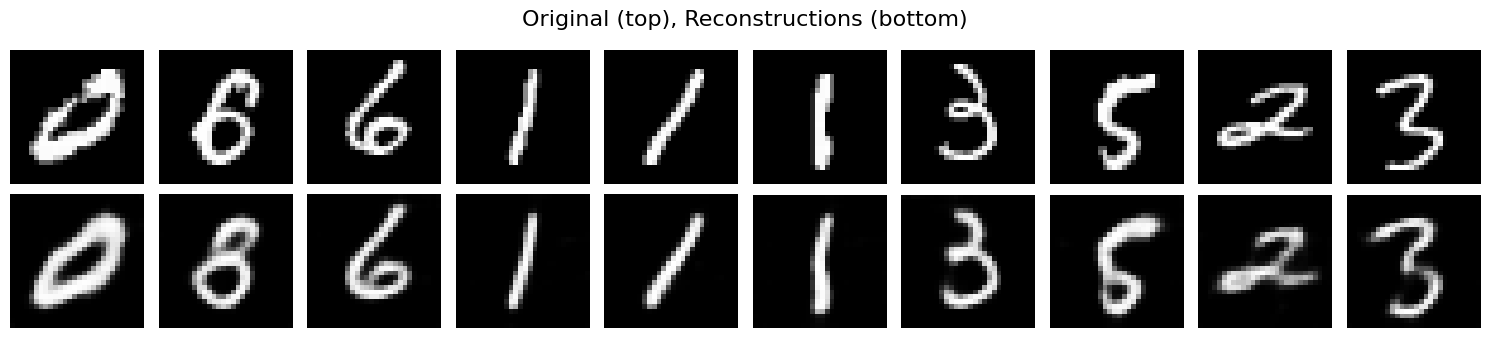

In [26]:
import random
import matplotlib.pyplot as plt

num_samples = 10
idxs = [random.randint(0, len(train_dataset) - 1) for _ in range(num_samples)]
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 4))

for i in range(num_samples):
    sample, label = train_dataset[idxs[i]]
    sample = sample.unsqueeze(0).to(device)
    with torch.no_grad():
        recon, _, _ = model(sample)
    sample = sample.squeeze().cpu().numpy()
    recon = recon.squeeze().cpu().numpy()
    recon = (recon + 1) / 2

    ax1 = axes[0, i]
    ax1.imshow(sample, cmap='gray')
    ax1.axis('off')
    ax2 = axes[1, i]
    ax2.imshow(recon, cmap='gray')
    ax2.axis('off')

fig.suptitle("Original (top), Reconstructions (bottom)", fontsize=16, y=0.88)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [27]:
encodings = [[] for _ in range(10)]
for i in range(len(train_dataset)):
    sample, label = train_dataset[i]
    sample = sample.unsqueeze(0).to(device)
    with torch.no_grad():
        _, indices = model.encode(sample)
        encodings[label].append(indices)

encodings = [torch.stack(encoding) for encoding in encodings]

In [28]:
# just checking
encodings[9].min(), encodings[9].max()

(tensor(29, device='cuda:0'), tensor(503, device='cuda:0'))

In [29]:
probs = []

for e in encodings:
    freqs = F.one_hot(e, num_classes=512).sum(dim=0)
    prob = freqs / freqs.sum(dim=-1, keepdim=True)
    probs.append(prob)

Text(0.5, 1.0, 'Sample of 3')

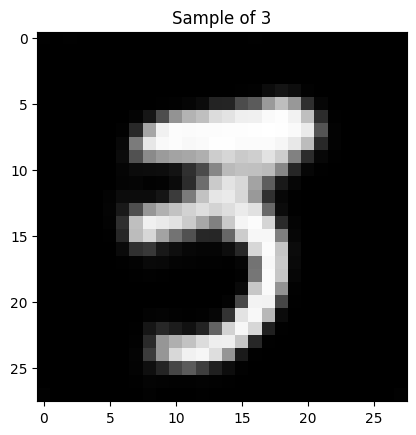

In [30]:
from torch.distributions import Categorical

def sample_of_type(typ):
    dist = Categorical(probs=probs[typ])
    indices = dist.sample()

    with torch.no_grad():
        new_sample = model.decode(indices)
    return new_sample

typ = 3
sample = sample_of_type(typ)
plt.imshow(sample.squeeze().cpu().numpy(), cmap='gray')
plt.title(f"Sample of {typ}")

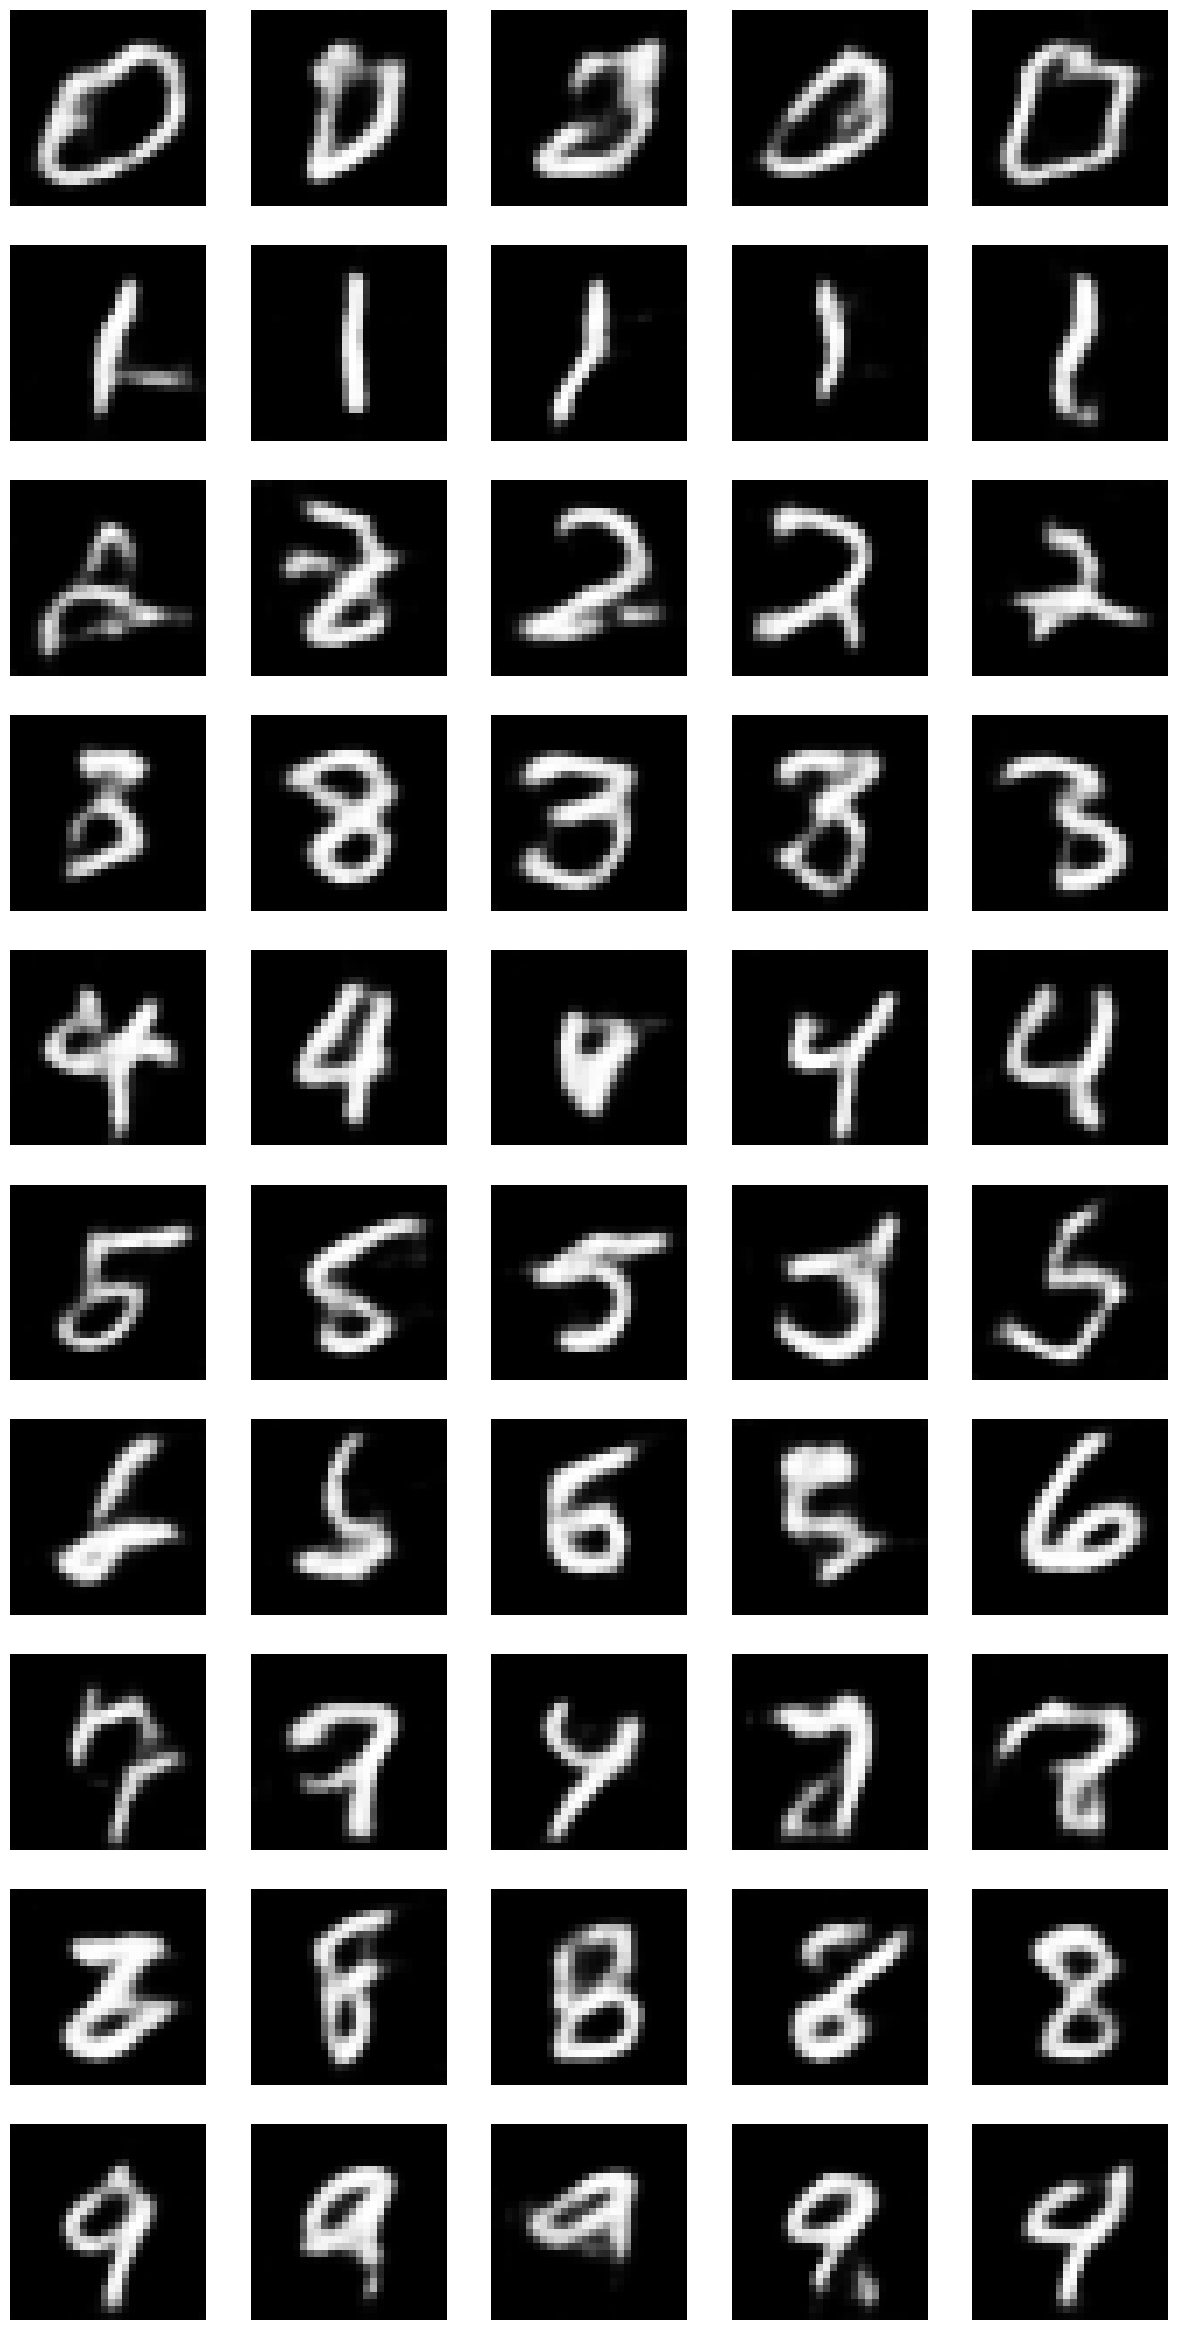

In [33]:
from torch.distributions import Categorical

fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15, 30))

for i in range(10):
    dist = Categorical(probs = probs[i])
    for j in range(5):
        indices = dist.sample()
        with torch.no_grad():
            new_sample = model.decode(indices)
        new_sample = new_sample.squeeze().cpu().numpy()
        new_sample = (new_sample + 1) / 2
        ax = axes[i, j]
        ax.imshow(new_sample, cmap='gray')
        ax.axis("off")


In [16]:
probs = torch.stack(probs)

In [17]:
probs = probs.reshape(-1, 9 * 512)

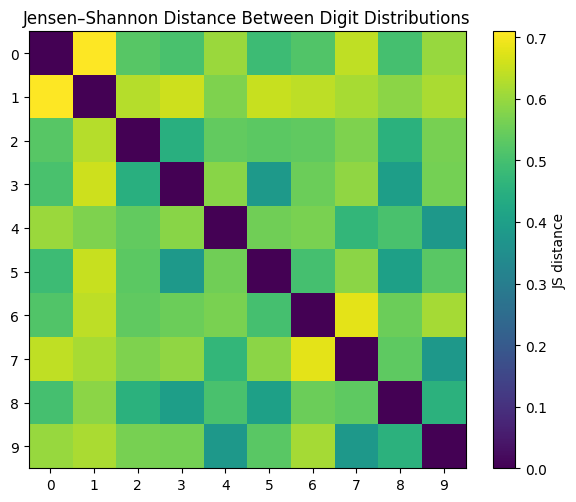

In [20]:
from scipy.spatial.distance import jensenshannon
import numpy as np

probs = probs.cpu()

js_distances = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        js_distances[i, j] = jensenshannon(probs[i], probs[j])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(js_distances, cmap='viridis', interpolation='nearest')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticklabels(np.arange(10))
ax.set_title('Jensen–Shannon Distance Between Digit Distributions')
fig.colorbar(im, ax=ax, label='JS distance')
plt.tight_layout()
plt.show()

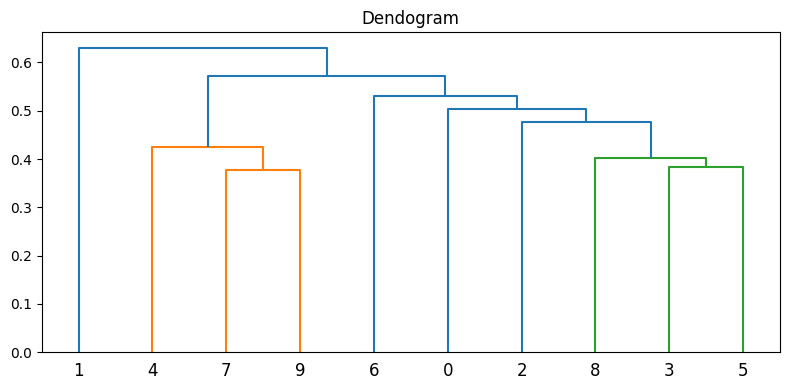

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

js_vec = squareform(js_distances)
link = linkage(js_vec, method='average')
plt.figure(figsize=(8,4))
dendrogram(
    link,
    labels=[str(i) for i in range(10)],
    leaf_rotation=0,
    leaf_font_size=12
)
plt.title("Dendogram")
plt.tight_layout()
plt.show()

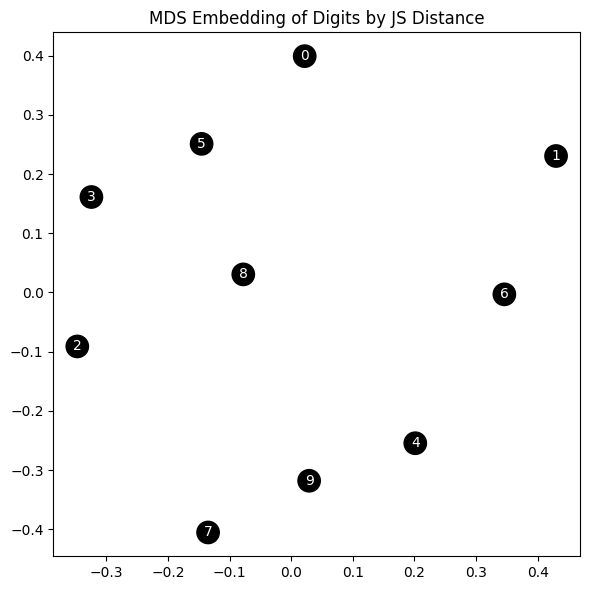

In [34]:
from sklearn.manifold import MDS

mds = MDS(
    n_components=2,
    dissimilarity='precomputed',
    random_state=42
)

coords = mds.fit_transform(js_distances)
plt.figure(figsize=(6,6))
plt.scatter(coords[:, 0], coords[:, 1], s=100)
for i in range(10):
    plt.text(coords[i, 0], coords[i, 1], str(i),
             ha='center', va='center', color='white',
             bbox=dict(facecolor='black', boxstyle='circle,pad=0.3'))
plt.title('MDS Embedding of Digits by JS Distance')
plt.grid(False)
plt.tight_layout()
plt.show()